In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as plty
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import pywt

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [5]:
calendar_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sell_prices_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
sales_train_validation_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')

# Samples

In [6]:
d_columns = sales_train_validation_df.columns[6:]

sample_1 = sales_train_validation_df.iloc[1][d_columns]
sample_2 = sales_train_validation_df.iloc[11][d_columns]
sample_3 = sales_train_validation_df.iloc[21][d_columns]

In [7]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(sample_1)),
                        y=sample_1,showlegend=False, mode='lines',
                        name='First Sample',marker_color='#0C629F'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2)),
                        y=sample_2,showlegend=False, mode='lines',
                        name='Second Sample',marker_color='#F36F62'), 
              row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3)),
                        y=sample_3,showlegend=False, mode='lines',
                        name='Third Sample',marker_color='#68D9D6'), 
              row=3, col=1)

fig.update_layout(height=1200, width=1000, title_text="Sample sales", template='plotly_white')

fig.show()

In [8]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(sample_1[200:300])),
                        y=sample_1[200:300],showlegend=False, mode='lines+markers',
                        name='First Sample',marker_color='#64B8F3'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_2[200:300])),
                        y=sample_2[200:300],showlegend=False, mode='lines+markers',
                        name='Second Sample',marker_color='#F36F62'), 
              row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(sample_3[200:300])),
                        y=sample_3[200:300],showlegend=False, mode='lines',
                        name='Third Sample',marker_color='#68D9D6'), 
              row=3, col=1)

fig.update_layout(height=900, width=900, title_text="Sample sales", template='plotly_white')

fig.show()

> **Observations:** The plots above reveal significant erratic and volatile patterns in the sales data. Sales occasionally drop to zero for several consecutive days, while at other times they remain at peak levels for extended periods. To identify underlying trends and improve forecasting accuracy, we need to apply denoising techniques to smooth out these fluctuations.

# Wavelet denoising

In [9]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

In [10]:
denoised_1 = denoise_signal(sample_1[200:300])
denoised_2 = denoise_signal(sample_2[200:300])
denoised_3 = denoise_signal(sample_3[200:300])

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(100),
                        y=sample_1[200:300],showlegend=False, mode='lines',
                        name='Original',marker_color='#64B8F3'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(200),
                        y=denoised_1,showlegend=False, mode='lines',
                        name='Denoised',marker_color='#0C629F'), 
              row=1, col=1)




fig.add_trace(go.Scatter(x=np.arange(100),
                        y=sample_2[200:300],showlegend=False, mode='lines',
                        name='Original',marker_color='#F2B963'), 
              row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(100),
                        y=denoised_2,showlegend=False, mode='lines',
                        name='Denoised',marker_color='#F36F62'), 
              row=2, col=1)



fig.add_trace(go.Scatter(x=np.arange(100),
                        y=sample_3[200:300],showlegend=False, mode='lines',
                        name='Original',marker_color='#A9E9E7'), 
              row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(100),
                        y=denoised_3,showlegend=False, mode='lines',
                        name='Denoised',marker_color='#20817D'), 
              row=3, col=1)

fig.update_layout(height=900, width=900, title_text="Original Signal vs Denoised", template='plotly_white')

fig.show()

# Average Smoothing

In [11]:
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)

In [12]:
denoised_1 = average_smoothing(sample_1[200:300])
denoised_2 = average_smoothing(sample_2[200:300])
denoised_3 = average_smoothing(sample_3[200:300])

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(100),
                        y=sample_1[200:300],showlegend=False, mode='lines',
                        name='Original',marker_color='#64B8F3'), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(100),
                        y=denoised_1,showlegend=False, mode='lines',
                        name='Denoised',marker_color='#0C629F'), 
              row=1, col=1)




fig.add_trace(go.Scatter(x=np.arange(100),
                        y=sample_2[200:300],showlegend=False, mode='lines',
                        name='Original',marker_color='#F2B963'), 
              row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(100),
                        y=denoised_2,showlegend=False, mode='lines',
                        name='Denoised',marker_color='#F36F62'), 
              row=2, col=1)



fig.add_trace(go.Scatter(x=np.arange(100),
                        y=sample_3[200:300],showlegend=False, mode='lines',
                        name='Original',marker_color='#A9E9E7'), 
              row=3, col=1)
fig.add_trace(go.Scatter(x=np.arange(100),
                        y=denoised_3,showlegend=False, mode='lines',
                        name='Denoised',marker_color='#20817D'), 
              row=3, col=1)

fig.update_layout(height=900, width=900, title_text="Original Signal vs Denoised", template='plotly_white')

fig.show()

> **Observations:** It's evident that average smoothing is less effective than wavelet denoising for uncovering macroscopic trends and patterns in the sales data. Despite applying average smoothing, significant noise remains, whereas wavelet denoising provides a clearer view of the underlying trends. However, average smoothing, or the "rolling mean," still has value and can be used to derive useful features for modeling.

# Creating sales data

In [13]:
store_ids = set(sales_train_validation_df['store_id'])
sales_df = sales_train_validation_df.set_index('id')[d_columns] \
    .T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

sales_df.index = pd.to_datetime(sales_df.index)

In [14]:
fig = go.Figure()
for store in store_ids:
    store_columns = [c for c in sales_df.columns if store in c]
    df = sales_df[store_columns].sum(axis=1)
    df.columns = ['date','sum']
    df = df.groupby(pd.Grouper(freq="M")).mean()
    fig.add_trace(go.Scatter(x=df.index, y=df, name=store))

fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Monthy Average Sales (per store)", template='plotly_white',
                     xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='12m', step='month', stepmode='backward'),
                dict(count=18, label='18m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    ))

> **Observations:**
> * There is a noticeable decline in sales during November and December.
> * Following this drop, sales typically rise in the new year, particularly in January and February.
> * Each year, sales peak between July and September.

In [15]:
fig = go.Figure()
for store in store_ids:
    store_columns = [c for c in sales_df.columns if store[:2] in c]
    df = sales_df[store_columns].sum(axis=1)
    df.columns = ['date','sum']
    df = df.groupby(pd.Grouper(freq="M")).mean()
    fig.add_trace(go.Scatter(x=df.index, y=df, name=store[:2]))

fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Monthy Average Sales CA vs TX vs WI", template='plotly_white',
                     xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='12m', step='month', stepmode='backward'),
                dict(count=18, label='18m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    ))
fig.update_traces(showlegend=True)

> **Observations:**
> * Sales from California have been the highest.
> * Texas and Winston have shown roughly the same amount of sales.
> * The rise and fall in sales have been similar for the three states in 5 years.

In [16]:
fig = go.Figure()
for store in store_ids:
    store_columns = [c for c in sales_df.columns if store in c]
    data = sales_df[store_columns].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=store))

fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per store)", template='plotly_white')

> Nearly every sales curve exhibits a "linear oscillation" trend at the macroscopic level. Essentially, sales fluctuate like a sine wave around a mean value that itself follows an upward linear trajectory. This suggests that sales are oscillating at progressively higher levels over time.</br>
This pattern is reminiscent of the business cycle, where short-term oscillatory fluctuations occur within the context of long-term linear growth.

In [17]:
fig = go.Figure()
for store in store_ids:
    store_columns = [c for c in sales_df.columns if store in c]
    data = sales_df[store_columns].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Box(x=[store]*1913, y=data, name=store))

fig.update_layout(
    height=500, 
    width=800,
    yaxis_title="Sales", 
    xaxis_title="Time", 
    title="Rolling Average Sales vs. Time (per store)", 
    template='plotly_white'
)

# Creating datasets

In [18]:
train_df = sales_df[-100:-30]
val_df = sales_df[-30:]

In [19]:
fig = make_subplots(rows=3, cols=1)

for idx in range(3):
    fig.add_trace(go.Scatter(x=train_df.index, y=train_df[train_df.columns[idx]]), row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=val_df.index, y=val_df[val_df.columns[idx]]), row=idx+1, col=1)

fig.update_layout(height=900, width=900, title_text="Train & Validation", template='plotly_white')

# Augmented Dicky-Fuller Test

In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_df[train_df.columns[0]])
print('Test Statistic : ',result[0])
print('P-value : ',np.round(result[1],decimals=15))

Test Statistic :  -8.2633841867922
P-value :  5.01e-13


> **Conclusion:**
> * *T-statistic = -8.2*, More negative means likey to be stationary.
> * With a *p-value less than 0.05*, we reject the null hypothesis that the time series is non-stationary. This indicates that our data is stationary.

# Auto-Correlation & Partial Auto-Correlation functions

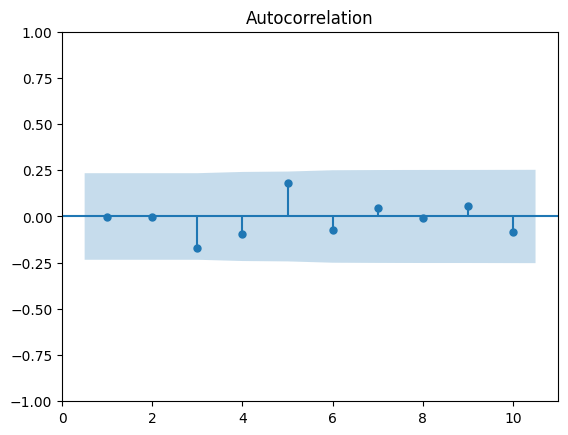

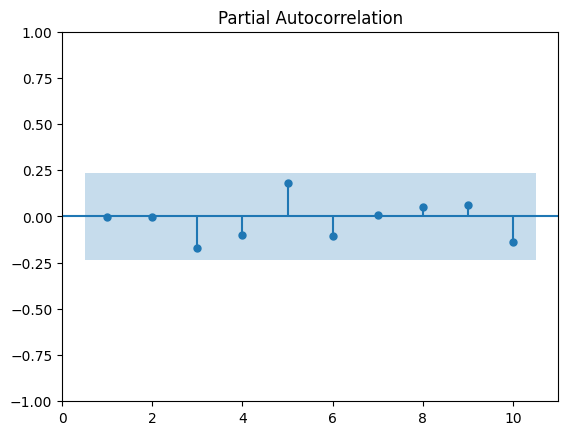

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_ = plot_acf(train_df[train_df.columns[0]], lags=10, zero=False, alpha=0.05)
_ = plot_pacf(train_df[train_df.columns[0]], lags=10, zero=False, alpha=0.05)

> **Observation :** Both the ACF and PACF plots exhibit a tail-off pattern and resemble a sinusoidal wave. This suggests that our data is best modeled by an ARMA (AutoRegressive Moving Average) model.

# ARIMA

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_aic_bic = []
# Loop over AR order
for p in range(3):
    #Loop over MA order
    for q in range(3):
        try:
            model = SARIMAX(train_df[train_df.columns[0]],order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

order_df

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:47

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75468D+00    |proj g|=  5.10945D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.109D-06   1.755D+00
  F =   1.7546813750940555     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:47

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23612D+01    |proj g|=  4.13109D+01

At iterate    5    f=  1.70076D+00    |proj g|=  2.08836D-01

At iterate   10    f=  1.56763D+00    |proj g|=  4.23081D-02

At iterate   15    f=  1.52270D+00    |proj g|=  2.93032D-02

At iterate   20    f=  1.50193D+00    |proj g|=  1.56708D-02

At iterate   25    f=  1.49867D+00    |proj g|=  1.15715D-02

At iterate   30    f=  1.49853D+00    |proj g|=  5.15781D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


,p,q,aic,bic
0,0,0,247.655393,249.903888
1,0,1,240.852685,245.349675
2,0,2,233.398759,240.144244
3,1,0,234.839494,239.336484
4,1,1,215.794390,222.539876
5,1,2,217.793950,226.787931
6,2,0,229.782325,236.527811
7,2,1,217.793951,226.787932
8,2,2,219.392157,230.634633


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56484D+00    |proj g|=  7.29066D-02

At iterate    5    f=  1.54176D+00    |proj g|=  3.56628D-02

At iterate   10    f=  1.50745D+00    |proj g|=  1.11140D-02

At iterate   15    f=  1.49919D+00    |proj g|=  1.12382D-03

At iterate   20    f=  1.49853D+00    |proj g|=  2.46813D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   6.426D-06   1.499D+00
  F =   1.4985313597245487     

CONVERG

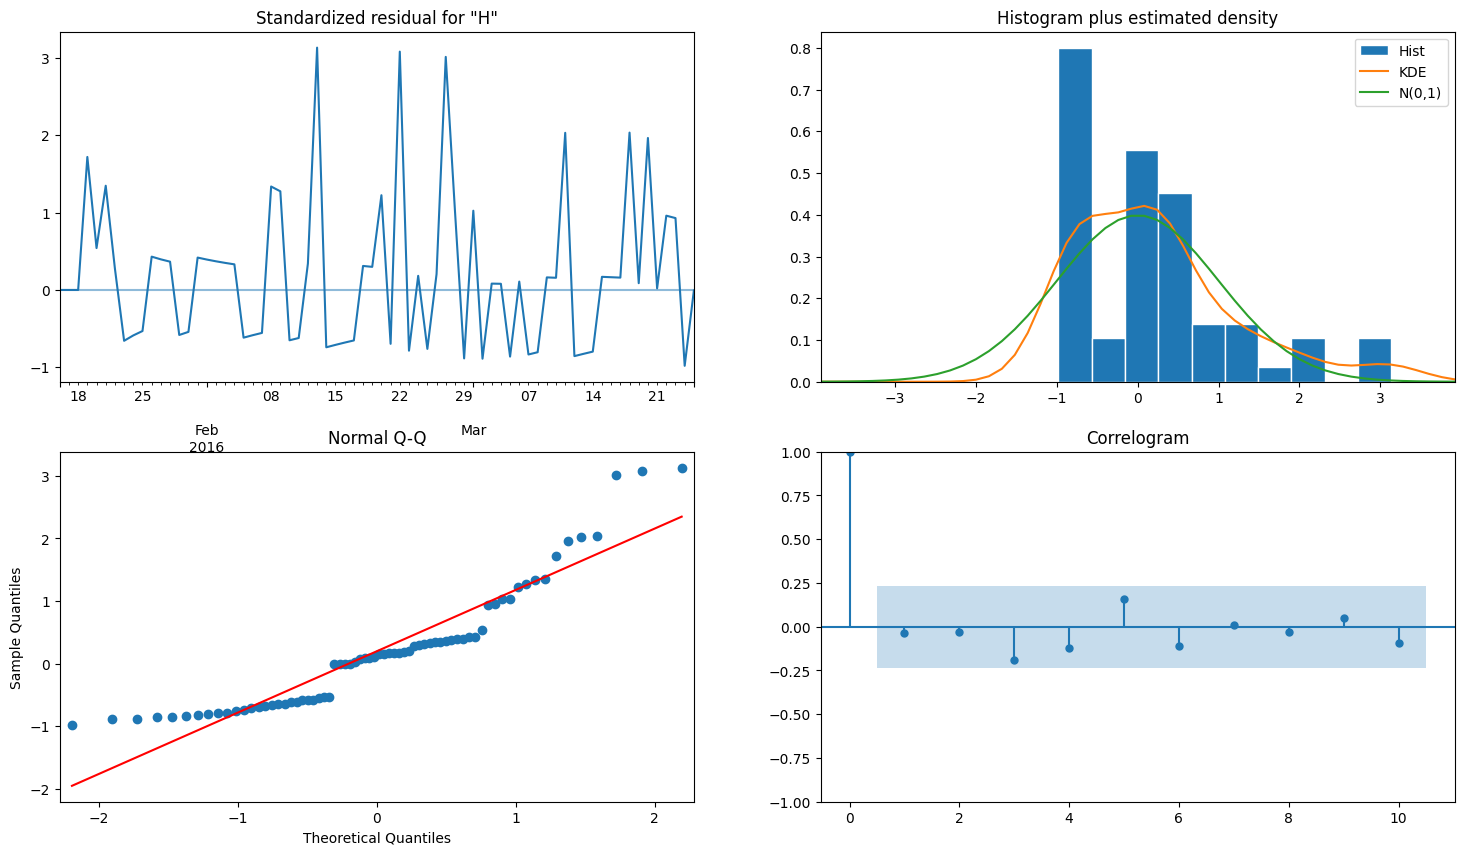

In [23]:
model = SARIMAX(train_df[train_df.columns[0]],order=(1,0,1))
results = model.fit()

residuals = results.resid
# Mean Absolute Error
mae = np.mean(np.abs(residuals))
print('Mean Absoulte Error : ', mae)


results.plot_diagnostics(figsize=(18,10))
_ = plt.show()

> **Observations :**
> * **Standardized Residuals:** There is no discernible structure in the residuals, indicating that our model is performing well.
> * **Histogram and Estimated Density:** The green and orange lines are nearly identical, suggesting that our model fits the data well.
> * **Normal Q-Q Plot:** The points do not align with the red line, indicating that the residuals are not normally distributed.
> * **Correlogram:** There is no significant correlation in the residuals, which means our model has effectively captured the key information from the data.

In [24]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     HOBBIES_1_001_CA_1_validation   No. Observations:                   70
Model:                          SARIMAX(1, 0, 1)   Log Likelihood                -104.897
Date:                           Mon, 02 Sep 2024   AIC                            215.794
Time:                                   21:13:53   BIC                            222.540
Sample:                               01-16-2016   HQIC                           218.474
                                    - 03-25-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.005    203.486      0.000       0.990       1.009
ma.L1         -0.9668      0.088    -11.022      0.000      -1.139      -0.795
sigma2         1.1315      0.160      7.057      0.000       0.817       1.446
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                21.12
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                             1.20
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
predictions = []

for idx in range(3):
    model = SARIMAX(train_df[train_df.columns[idx]],order=(1,0,1))
    results = model.fit()
    predictions.append(results.forecast(30))

predictions = np.array(predictions).reshape((-1, 30))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56484D+00    |proj g|=  7.29066D-02

At iterate    5    f=  1.54176D+00    |proj g|=  3.56628D-02

At iterate   10    f=  1.50745D+00    |proj g|=  1.11140D-02

At iterate   15    f=  1.49919D+00    |proj g|=  1.12382D-03

At iterate   20    f=  1.49853D+00    |proj g|=  2.46813D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   6.426D-06   1.499D+00
  F =   1.4985313597245487     

CONVERG

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


In [26]:
fig = make_subplots(rows=3, cols=1)

for idx in range(3):
    fig.add_trace(go.Scatter(x=train_df.index, y=train_df[train_df.columns[idx]]), row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=val_df.index, y=val_df[val_df.columns[idx]]), row=idx+1, col=1)
    fig.add_trace(go.Scatter(x=val_df.index, y=predictions[idx]), row=idx+1, col=1)
    
fig.update_layout(height=900, width=900, title_text="Predictions ARIMA", template='plotly_white')

# Seasonal Decomposition

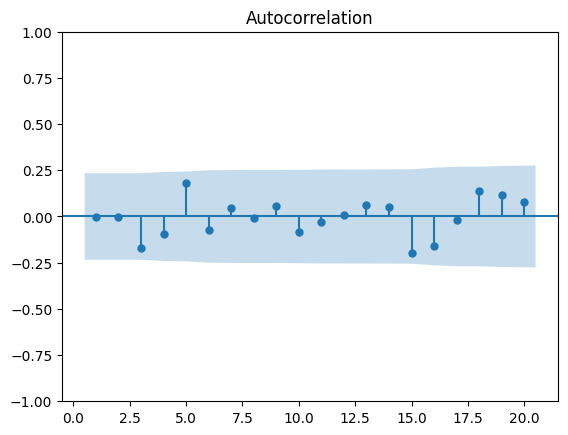

In [27]:
# Identifying seasonal periods
_ = plot_acf(train_df[train_df.columns[0]], zero=False, lags=20)

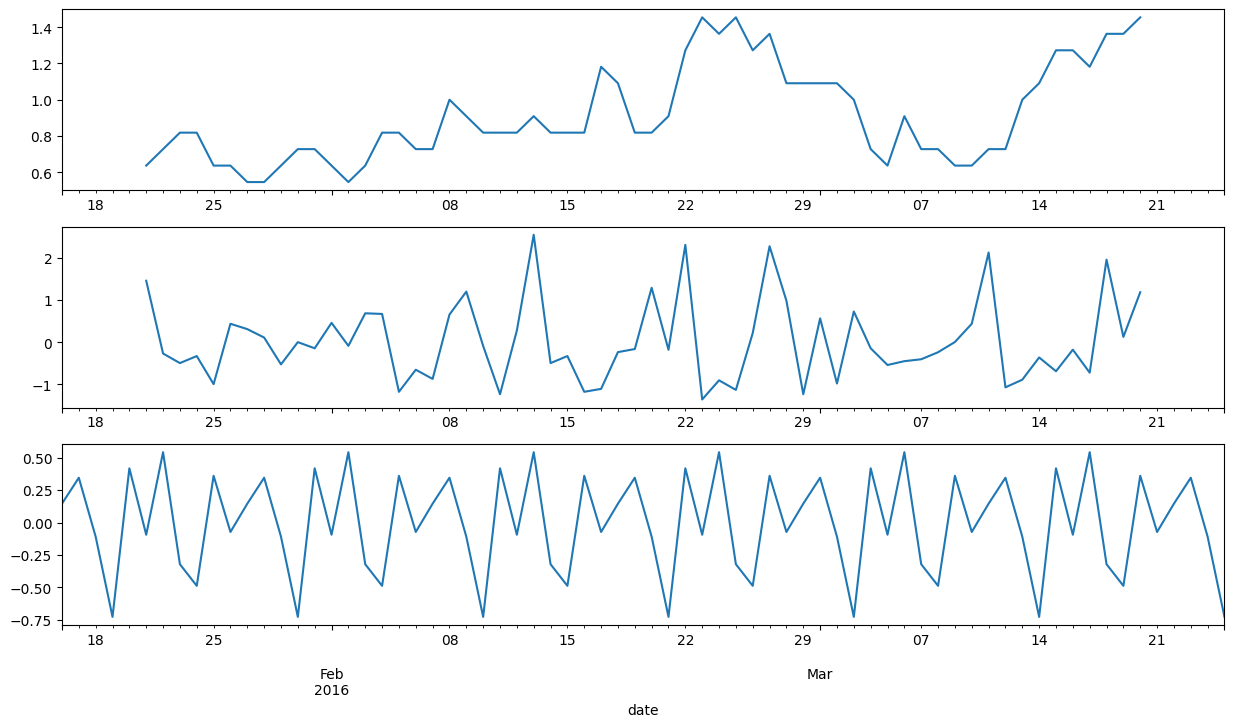

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(train_df[train_df.columns[0]], period = 11)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1)
res.resid.plot(ax=ax2)
res.seasonal.plot(ax=ax3)

fig.show()

# SARIMA

In [32]:
!pip install -q pmdarima

In [33]:
import pmdarima as pm


results = pm.auto_arima(train_df[train_df.columns[0]],
                           d=0, 
                           start_p=1, 
                           start_q=1,
                           max_p=3, 
                           max_q=3,
                           seasonal=True , 
                           m=11, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2,
                           information_criterion='aic', 
                           trace = True, 
                           error_action = 'ignore', 
                           stepwise=True 
                           )

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[11] intercept   : AIC=206.207, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[11] intercept   : AIC=221.408, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[11] intercept   : AIC=207.505, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[11] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[11]             : AIC=219.994, Time=0.03 sec
 ARIMA(1,0,1)(0,1,1)[11] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,0,1)(1,1,0)[11] intercept   : AIC=209.481, Time=0.28 sec
 ARIMA(1,0,1)(2,1,1)[11] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(1,0,1)(1,1,2)[11] intercept   : AIC=inf, Time=2.05 sec
 ARIMA(1,0,1)(0,1,0)[11] intercept   : AIC=225.258, Time=0.17 sec
 ARIMA(1,0,1)(0,1,2)[11] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(1,0,1)(2,1,0)[11] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,1)(2,1,2)[11] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,0,1)(1,1,1)[11] intercept   : AIC=204.207, Time=0.34 sec
 ARIMA(0,0,1)(1,1,0)[11] intercept   : AIC=207.495, Time=0.11

In [34]:
predictions = []

for idx in range(3):
    model = SARIMAX(train_df[train_df.columns[idx]],order=(0,0,0), seasonal_order=(1,1,1,11), trend='c')
    results = model.fit()
    predictions.append(results.forecast(30))

predictions = np.array(predictions).reshape((-1, 30))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45023D+00    |proj g|=  1.74403D-01

At iterate    5    f=  1.38973D+00    |proj g|=  2.15200D-02

At iterate   10    f=  1.38756D+00    |proj g|=  8.08837D-03

At iterate   15    f=  1.38720D+00    |proj g|=  1.31702D-03

At iterate   20    f=  1.38720D+00    |proj g|=  1.15133D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   1.151D-05   1.387D+00
  F =   1.3871992296478841     

CONVERG

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.



At iterate   10    f=  5.65405D-01    |proj g|=  4.70734D-02

At iterate   15    f=  5.63301D-01    |proj g|=  1.74434D-02

At iterate   20    f=  5.62907D-01    |proj g|=  1.26086D-02

At iterate   25    f=  5.62845D-01    |proj g|=  2.70037D-03

At iterate   30    f=  5.62839D-01    |proj g|=  7.14136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     49      1     0     0   4.894D-04   5.628D-01
  F =  0.56283881435619199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71438D+00    |proj g|=  8.36219D-01

At iterate    5    f=  1.15599D+00    |proj g|=  1.17861D-02

At iterate   10    f=  1.15525D+00    |proj g|=  9.87268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   2.837D-06   1.155D+00
  F =   1.1552232916408047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


## Modelling on entire one year of data in California

In [35]:
# Creating monthly average for CA
store_columns = [c for c in sales_df.columns if 'CA' in c]
df = sales_df[store_columns].sum(axis=1)
df.columns = ['date','sum']
df = df.groupby(pd.Grouper(freq="M")).mean()

In [36]:
train_df = df.loc['2012-12-31':'2015-12-31']
val_df = df.loc['2015-12-31':]

### First Seasonal Order

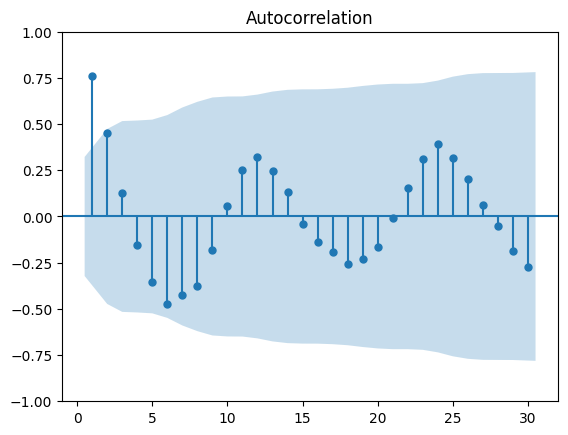

In [37]:
_ = plot_acf(train_df, lags=30, zero=False)

In [38]:
import pmdarima as pm


results = pm.auto_arima(train_df,
                           d=0, 
                           start_p=1, 
                           start_q=1, 
                           max_p=3, 
                           max_q=3,
                           seasonal=True , 
                           m=12, 
                           D=2, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2,
                           information_criterion='aic', 
                           trace = True, 
                           error_action = 'ignore', 
                           stepwise=True
                           )

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,2,1)[12]             : AIC=220.828, Time=1.15 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=234.568, Time=0.04 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=226.512, Time=0.19 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=229.805, Time=0.35 sec
 ARIMA(1,0,1)(0,2,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(1,0,1)(1,2,0)[12]             : AIC=225.976, Time=0.44 sec
 ARIMA(1,0,1)(2,2,1)[12]             : AIC=222.076, Time=2.08 sec
 ARIMA(1,0,1)(1,2,2)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(1,0,1)(0,2,0)[12]             : AIC=228.996, Time=0.13 sec
 ARIMA(1,0,1)(0,2,2)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(1,0,1)(2,2,0)[12]             : AIC=214.969, Time=1.53 sec
 ARIMA(0,0,1)(2,2,0)[12]             : AIC=224.630, Time=0.86 sec
 ARIMA(1,0,0)(2,2,0)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(2,0,1)(2,2,0)[12]             : AIC=224.755, Time=2.09 sec
 ARIMA(1,0,2)(2,2,0)[12]             : AIC=223.65

## Forecasting 12 months data for california

In [75]:
predictions = []


model = SARIMAX(train_df,order=(1,0,1), seasonal_order=(2,2,0,12), trend='c')
results = model.fit()
predictions = results.forecast(11)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12827D+00    |proj g|=  9.51675D-01

At iterate    5    f=  2.92216D+00    |proj g|=  2.01191D-01

At iterate   10    f=  2.90857D+00    |proj g|=  2.04481D-02

At iterate   15    f=  2.89674D+00    |proj g|=  6.06542D-02

At iterate   20    f=  2.89577D+00    |proj g|=  1.57516D-03

At iterate   25    f=  2.89577D+00    |proj g|=  1.01486D-03

At iterate   30    f=  2.89573D+00    |proj g|=  2.31395D-02

At iterate   35    f=  2.88755D+00    |proj g|=  1.42924D-01

At iterate   40    f=  2.78564D+00    |proj g|=  1.91456D-01

At iterate   45    f=  2.75767D+00    |proj g|=  1.39048D-01

At iterate   50    f=  2.73758D+00    |proj g|=  2.23735D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [74]:
predictions = np.array(predictions).reshape((-1, 11))

In [78]:
predictions

,predicted_mean
2016-01-31,16840.368451
2016-02-29,17309.828259
2016-03-31,17891.301740
2016-04-30,18245.337156
2016-05-31,18472.014262
2016-06-30,19612.679648
2016-07-31,20240.480938
2016-08-31,20998.773520
2016-09-30,19868.688301
2016-10-31,19742.480700


In [76]:
train_df = pd.DataFrame(train_df)
val_df = pd.DataFrame(val_df)
predictions = pd.DataFrame(predictions)

In [83]:
predictions[predictions.columns[0]]

2016-01-31    16840.368451
2016-02-29    17309.828259
2016-03-31    17891.301740
2016-04-30    18245.337156
2016-05-31    18472.014262
2016-06-30    19612.679648
2016-07-31    20240.480938
2016-08-31    20998.773520
2016-09-30    19868.688301
2016-10-31    19742.480700
2016-11-30    17427.856002
Freq: ME, Name: predicted_mean, dtype: float64

In [88]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = train_df.index, y = train_df[train_df.columns[0]].values))
fig.add_trace(go.Scatter(x = val_df.index, y = val_df[val_df.columns[0]].values))
fig.add_trace(go.Scatter(x = predictions.index, y = predictions[predictions.columns[0]].values))

fig.update_layout(height=600, width=900, title_text="Predictions Seasonal ARIMA", template='plotly_white')

---